In [299]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Introduction

### Example 1.2: simple binomial test

In [300]:
num_simulation = 1000
num_tosses = 6
obs_num_heads = 1

all_results = np.zeros(num_simulation)

for cur_sim in range(num_simulation):
    cur_tosses = np.zeros(num_tosses)
    for i in range(num_tosses):
        cur_tosses[i] = np.random.choice([0, 1])

    all_results[cur_sim] = np.sum(cur_tosses)

sim_pval = np.sum(all_results <= obs_num_heads) / num_simulation

print(f"Simulated p-value: {sim_pval}")

Simulated p-value: 0.106


Plotting the distribution of the test statistic under the null

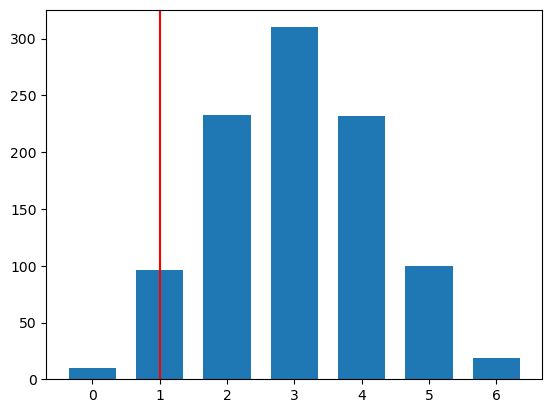

In [327]:
bins = np.arange(all_results.min(), all_results.max() + 2) - 0.5

plt.hist(all_results, rwidth=.7, bins=bins);
plt.axvline(obs_num_heads, color='red');
plt.show()

## Permutation tests

### Example 1.3: A/B Testing

Also known as two sample testing. 

Consider an A/B test where each user outcome is binary (click = 1, no click = 0). We want to test whether the click-through rates differ between the two groups:

$H_0: p_A = p_B \quad \text{vs.} \quad H_1: p_A\neq p_B$

A **permutation test** constructs a null distribution by repeatedly shuffling the A/B labels.

Under the null hypothesis, the labels do not carry information about CTR; that is, the outcomes are exchangeable across groups. Therefore, conditional on the observed outcomes, every reassignment of the A/B labels (keeping the group sizes fixed) is equally likely.

To test $H_0$:

- Compute a test-statistic from observed data (e.g. $T^{obs} = |\widehat{p}_A - \widehat{p}_B|$)
- Randomly shuffle the A/B labels many times and recompute test statistic each time 
- Compare $T^{obs}$ to the permutation distribution to obtain a $p$-value:

$$p\text{-val} = \frac{1}{S}\sum_{s=1}^S \mathbb{I}(T^{(s)} \geq T^{obs})$$

Simulated p-value: 0.137


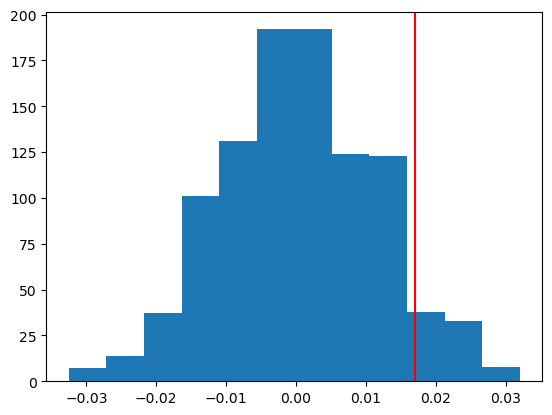

In [302]:
n_sim = 1000

my_viewsA = 98
my_viewsB = 162
all_views = my_viewsA + my_viewsB

n_impsA = 1000
n_impsB = 2000
all_imps = n_impsA + n_impsB

obs_T = abs(my_viewsA / n_impsA - my_viewsB / n_impsB)

null_Ts = np.zeros(n_sim) ## what we called "all_results" from before

for cur_sim in range(n_sim):
    pool = np.array([1] * all_views + [0] * (all_imps - all_views))
    impsA = np.random.choice(pool, n_impsA, replace=False)
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA

    diff = viewsA / n_impsA - viewsB / n_impsB
    null_Ts[cur_sim] = diff

sim_pval = np.sum(np.abs(null_Ts) >= np.abs(obs_T)) / n_sim

print(f"Simulated p-value: {sim_pval}")

plt.hist(null_Ts, bins=12)
plt.axvline(abs(obs_T), color='red')
plt.show()

### Example 1.4: independence test for contingency tables

We have paired data $(X_1,Y_1), \dots, (X_n, Y_n)$.

We can use permutations to test:

$$H_0: X \text{ independent of } Y \quad \text{vs.}\quad H_1: X \text{ not independent of } Y$$

Under the null, shuffling which values are paired does not change the distribution (because $X$ and $Y$ are independent). 

That is, under the null, $(X_4, Y_1), (X_{32}, Y_2), ... (X_5, Y_n)$ has the same distribution as the original data. 

In [303]:
K1 = 3
K2 = 2

con_table = [[350, 1200, 450], 
             [20, 120, 60]]

con_table = np.array(con_table)

column_sums = np.sum(con_table, axis=0)
row_sums = np.sum(con_table, axis=1)

In [304]:
## compute chi-squared test statistic
E = np.zeros((K2, K1))
for i in range(K2):
    for j in range(K1):
        E[i, j] = row_sums[i] * column_sums[j] / np.sum(con_table)

obs_T = np.sum((con_table - E)**2 / E)

n = int(np.sum(con_table))

In [305]:
## convert contingency table to data pairs
data_pairs = []
for i in range(K2):
    for j in range(K1):
        for _ in range(int(con_table[i, j])):
            data_pairs.append([i, j])
data_pairs = np.array(data_pairs)

[[ 332. 1205.  463.]
 [  38.  115.   47.]]
Simulated p-value using test statistic 1 = 0.011


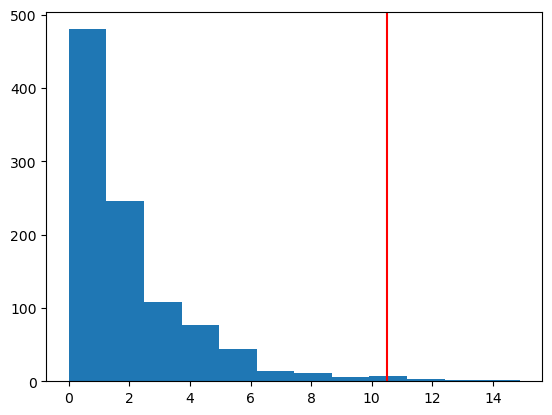

In [306]:
n_sim = 1000

all_null_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    ## permute the first column of data_pairs
    cur_sim_data = np.column_stack((np.random.choice(data_pairs[:, 0], n, replace=False), data_pairs[:, 1]))

    ## convert cur_sim_data to contingency table
    cur_sim_con_table = np.zeros((K2, K1))
    for i in range(n):
        cur_sim_con_table[cur_sim_data[i, 0], cur_sim_data[i, 1]] += 1
    
    null_T = np.sum((cur_sim_con_table - E)**2 / E)
    all_null_Ts[cur_sim] = null_T

print(cur_sim_con_table)

## compute p-value
p_value = np.mean(all_null_Ts >= obs_T)
print(f"Simulated p-value using test statistic 1 = {p_value}")

plt.hist(all_null_Ts, bins=12);
plt.axvline(obs_T, color='red');

In [307]:
## Use traditional pearson chi-squared test
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(con_table)
print(f"CLT-based p-value = {p:.4f}")

CLT-based p-value = 0.0053


### Example 1.5: independence test for continuous data

np.float64(0.7350457786848433)

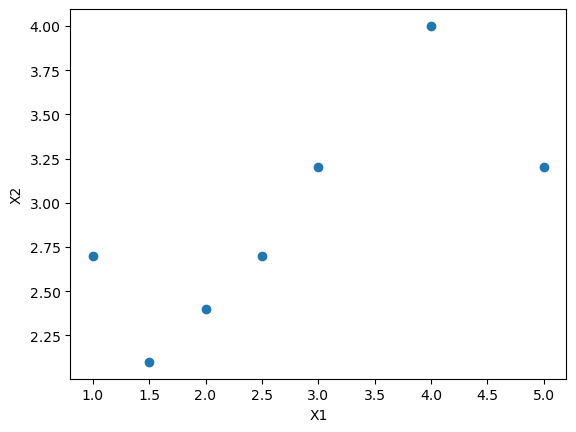

In [308]:
# Creating the X matrix
X = np.array([[2.5, 2.7], [4, 4.0], [5, 3.2], [1, 2.7], [3, 3.2], [2, 2.4], [1.5, 2.1]])

## plot variable X[, 0] vs X[, 1]
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")

np.corrcoef(X[:, 0], X[:, 1])[0, 1]


Simulated p-value: 0.046


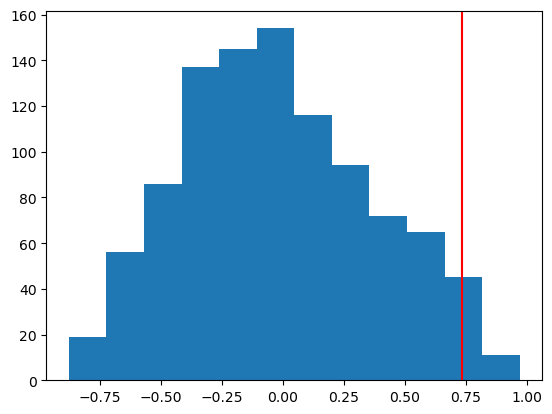

In [309]:
n = X.shape[0]

# Calculating the correlation of the original data
obs_T = np.corrcoef(X[:, 0], X[:, 1])[0, 1]

n_sim = 1000

null_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    # Shuffling only the first column of X
    Xprime = np.column_stack((np.random.choice(X[:, 0], n, replace=False), X[:, 1]))
    null_Ts[cur_sim] = np.corrcoef(Xprime[:, 0], Xprime[:, 1])[0, 1]

# Calculating the proportion of simulations where the absolute correlation is greater than my_corr
sim_pval = np.sum(np.abs(null_Ts) >= obs_T) / n_sim

print(f"Simulated p-value: {sim_pval}")

plt.hist(null_Ts, bins=12)
plt.axvline(obs_T, color='red')
plt.show()


### Example 1.6: independence test using Spearman's rho

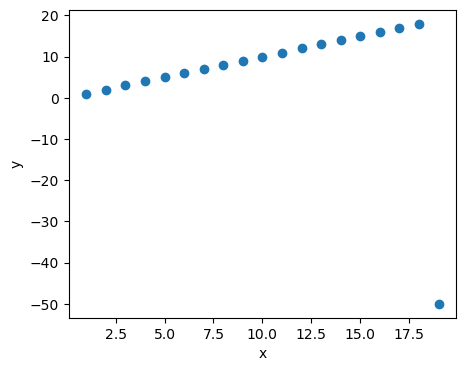

In [328]:
x = np.arange(1, 20)
y = np.arange(1, 20)
y[-1] = -50

n = len(x)

plt.figure(figsize=(5,4))
plt.scatter(x, y);
plt.xlabel('x');
plt.ylabel('y');

Simulated correlation p-value: 1.0
Simulated spearman's p-value: 0.0


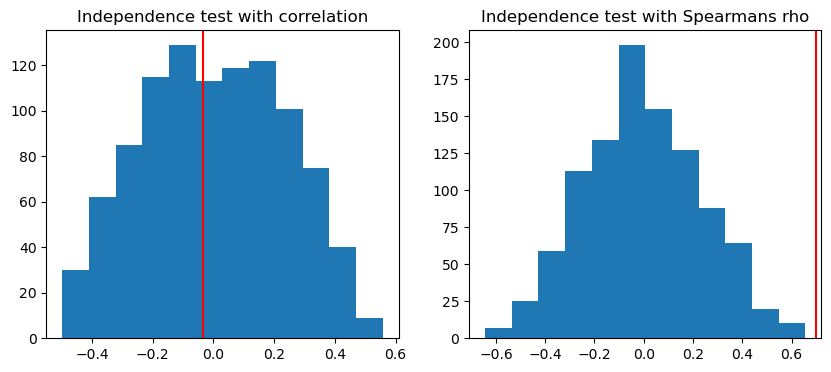

In [311]:
# correlation of original data
obs_corr = np.corrcoef(x, y)[0,1]
# spearman rho
rank_x = stats.rankdata(x)
rank_y = stats.rankdata(y)
obs_spearman = np.corrcoef(rank_x, rank_y)[0,1]

n_sim = 1000

null_corr = np.zeros(n_sim)
null_spearman = np.zeros(n_sim)

for cur_sim in range(n_sim):
    
    x_shuffle = np.random.choice(x, n, replace=False) 
    null_corr[cur_sim] = np.corrcoef(x_shuffle, y)[0, 1]
    rank_x = stats.rankdata(x_shuffle)
    null_spearman[cur_sim] = np.corrcoef(rank_x, rank_y)[0, 1]

# Calculating the proportion of simulations where the absolute correlation is greater than obs_corr
corr_pval = np.sum(np.abs(null_corr) >= obs_corr) / n_sim
print(f"Simulated correlation p-value: {corr_pval}")

spearman_pval = np.sum(np.abs(null_spearman) >= obs_spearman) / n_sim
print(f"Simulated spearman's p-value: {spearman_pval}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(null_corr, bins=12)
ax1.axvline(obs_corr, color='red')
ax1.set_title('Independence test with correlation')

ax2.hist(null_spearman, bins=12)
ax2.axvline(obs_spearman, color='red')
ax2.set_title('Independence test with Spearmans rho')

plt.show()


## Estimating sampling distributions

**Goal**: Given a sample $X_1,\dots, X_n\sim p(x|\theta)$, what is the standard error for an estimator $\widehat{\theta}$ of $\theta$? 

- For example, the sample mean $\bar{X}$ is an estimator for the population mean $\mu$. The Central Limit Theorem tells us that $\bar{X} \sim N(\mu, \sigma^2/n)$, where $\sigma^2$ is the population variance.

**Monte Carlo**: use repeated sampling from $p(x|\theta)$

- Example: obtain sampling distribution of the median of the exponential distribution

    - Draw $S$ samples, each of size $n$, from the exponential distribution
    - For each sample, calculate the median 
    $$\widehat{\theta}^{(s)} = \text{median}(X_1^{(s)}, \dots, X_n^{(s)})$$
    - Now you have an approximate distribution based on $(\widehat{\theta}^{(1)},\dots, \widehat{\theta}^{(S)})$

![](fig/sample_animation.gif)

## The Bootstrap

**Problem**: If we do not know $p(x|\theta)$, we cannot repeatedly sample from the population

The **bootstrap** (Efron, 1979) refers to a simulation-based approach to understand the accuracy of statistical estimates.

- Instead of sampling from $p(x|\theta)$, the bootstrap involves sampling from an observed sample $x_1,\dots, x_n$, *with replacement*
- That is, the bootstrap approximates $p(x|\theta)$ with the empirical distribution of $x_1,\dots, x_n$.

![](fig/bootstrap_animation.gif)

### Example 1.7: confidence interval for the median

Here is a sample $X_1,\dots, X_n$ from the exponential distribution.

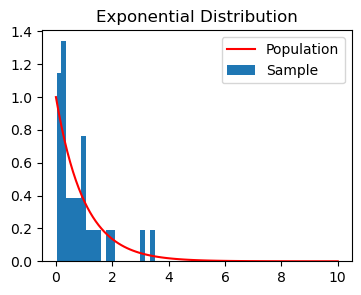

In [329]:
# draw sample
np.random.seed(42)
n = 30
x = np.random.exponential(scale=1, size=n)  

# calculate sample estimate
med_hat = np.median(x)

# get population distribution for plotting
x_vals = np.linspace(0, 10, 100)
pdf_vals = scipy.stats.expon.pdf(x_vals)

plt.figure(figsize=(4,3))
plt.plot(x_vals, pdf_vals, 'r', label='Population');
plt.hist(x, density=True, label='Sample', bins=20);
plt.title('Exponential Distribution');
plt.legend();

In [ ]:
print(f"Estimated: {med_hat:.3f}")

We use the bootstrap to obtain bootstrap samples, and calculate the median of each of the samples.

In [313]:
n_boot = 1000

boot_med_hats = np.zeros(n_boot)

for cur_boot in range(n_boot):
    xboot = np.random.choice(x, n, replace=True)
    boot_med_hats[cur_boot] = np.median(xboot)

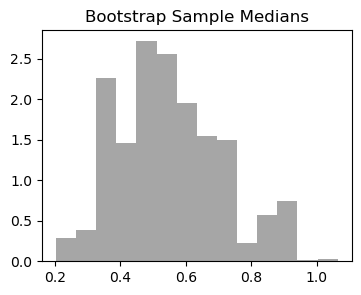

In [325]:
plt.figure(figsize=(4,3))
bins_medians = np.linspace(min(boot_med_hats), max(boot_med_hats), 15)
plt.hist(boot_med_hats, bins=bins_medians,density=True, color='grey', alpha=0.7);
plt.title('Bootstrap Sample Medians');

We show two ways to compute a confidence interval for the sample median, $\widehat{m}$

1. Normal approximation using standard deviation of bootstrap medians

$$ [\widehat{m} - z_{1-\alpha/2} sd(\widehat{m}), \widehat{m} + z_{1-\alpha/2} sd(\widehat{m})]$$

where $z_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the Gaussian distribution.

In [315]:
z_alpha = stats.norm.ppf(0.975)  # z_{1-alpha/2} for alpha=0.05
lower_quantile = med_hat - z_alpha * np.std(boot_med_hats)
upper_quantile = med_hat + z_alpha * np.std(boot_med_hats)

In [316]:
print(f"Bootstrap normal confidence interval: ({lower_quantile:.3f}, {upper_quantile:.3f})")

Bootstrap normal confidence interval: (0.198, 0.837)


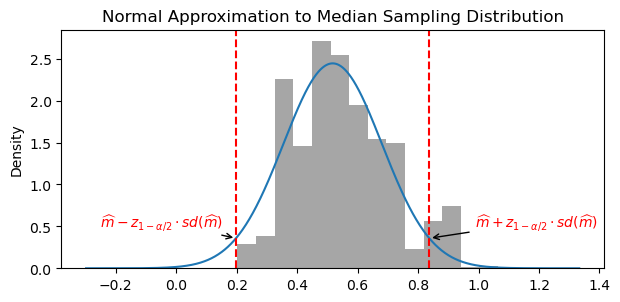

In [330]:
#| echo: false
x_vals = np.linspace(med_hat - 5 * np.std(boot_med_hats), med_hat + 5 * np.std(boot_med_hats), 1000)
pdf_vals = stats.norm.pdf(x_vals, loc=med_hat, scale=np.std(boot_med_hats))

plt.figure(figsize=(7, 3.1))
plt.plot(x_vals, pdf_vals)

bins_medians = np.linspace(min(boot_med_hats), max(boot_med_hats), 15)
plt.hist(boot_med_hats, density=True, bins = bins_medians, color='grey', alpha=0.7)

plt.axvline(lower_quantile, color='red', linestyle='--')
plt.axvline(upper_quantile, color='red', linestyle='--')

plt.annotate(r'$\widehat{m} - z_{1-\alpha/2} \cdot sd(\widehat{m})$', xy=(lower_quantile, stats.norm.pdf(lower_quantile, loc=med_hat, scale=np.std(boot_med_hats))), 
             xytext=(lower_quantile - 0.45, 0.5), arrowprops=dict(arrowstyle='->'), color='red')
plt.annotate(r'$\widehat{m} + z_{1-\alpha/2} \cdot sd(\widehat{m})$', xy=(upper_quantile, stats.norm.pdf(upper_quantile, loc=med_hat, scale=np.std(boot_med_hats))), 
             xytext=(upper_quantile + 0.15, 0.5), arrowprops=dict(arrowstyle='->'), color='red')
plt.ylabel('Density')
plt.title('Normal Approximation to Median Sampling Distribution')
plt.show()

2. Quantiles of bootstrap medians

$$ [\widehat{Q}_{\alpha/2}, \widehat{Q}_{1-\alpha/2}]$$

where $\widehat{Q}_{\alpha/2}$ is the $\alpha/2$ sample quantile of the bootstrap medians. 

In [318]:
q025 = np.quantile(boot_med_hats, 0.025)
q975 = np.quantile(boot_med_hats, 0.975)
print(f"Bootstrap quantile confidence interval: ({q025:.3f}, {q975:.3f})")

Bootstrap quantile confidence interval: (0.291, 0.905)


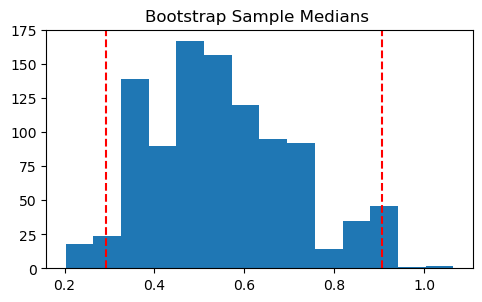

In [319]:
#| echo: false
plt.figure(figsize=(5.5, 3.1))
bins_medians = np.linspace(min(boot_med_hats), max(boot_med_hats), 15)
plt.hist(boot_med_hats, bins=bins_medians);

plt.axvline(q025, color='red', linestyle='--')
plt.axvline(q975, color='red', linestyle='--')
plt.title('Bootstrap Sample Medians ')
plt.show()


### Example 1.8: verifying the validity of bootstrap confidence intervals

We show the bootstrap confidence intervals have almost $(1-\alpha)/%$ coverage.

- We draw a sample from the Poisson($\lambda$) distribution with $\lambda=1$. The population mean is $1$.

- We draw bootstrap samples and calculate a confidence interval for the mean using the normal approximation

- We then record how many intervals contain the population mean

Percent of experiments where the confidence interval contains the true mean: 0.92


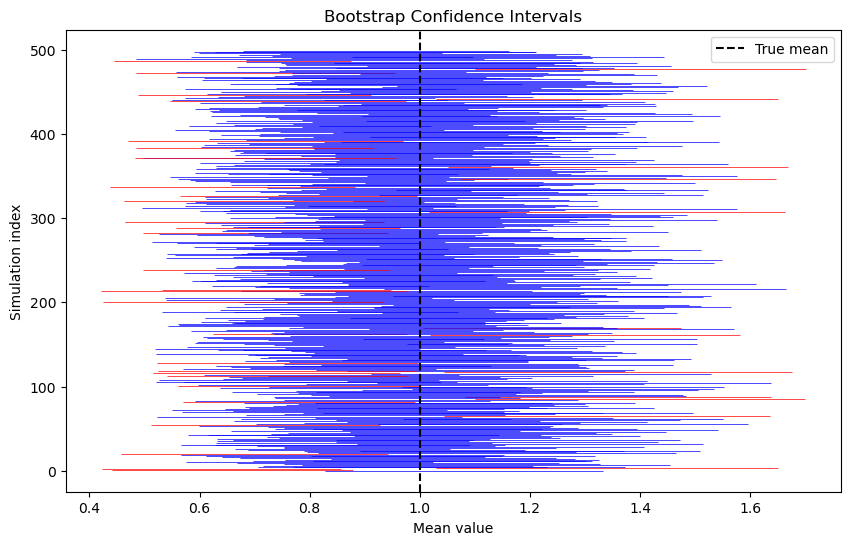

In [335]:
n_sim = 500
successes = np.zeros(n_sim)
z_alpha = stats.norm.ppf(0.975)  # z_{1-alpha/2} for alpha=0.05
lower_bounds = []
upper_bounds = []

for cur_sim in range(n_sim):
    n = 50
    x = np.random.poisson(lam=1, size=n)  # Poisson distribution with lambda=1
    mu = 1

    muhat = np.mean(x)

    n_boot = 500
    boot_muhats = np.zeros(n_boot)
    
    for cur_boot in range(n_boot):
        xboot = np.random.choice(x, n, replace=True)
        boot_muhats[cur_boot] = np.mean(xboot)

    boot_std = np.std(boot_muhats) 
    boot_ci = [muhat - z_alpha * boot_std, muhat + z_alpha * boot_std]
    lower_bounds.append(muhat - z_alpha * boot_std)
    upper_bounds.append(muhat + z_alpha * boot_std)

    if boot_ci[0] <= mu <= boot_ci[1]:
        successes[cur_sim] = 1

percent_success = np.sum(successes) / n_sim

print(f"Percent of experiments where the confidence interval contains the true mean: {percent_success}")

# Plot the confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(n_sim):
    color = 'blue' if successes[i] else 'red'
    ax.hlines(i, lower_bounds[i], upper_bounds[i], colors=color, linewidth=0.5)

ax.axvline(mu, color='black', linestyle='--', label='True mean')
ax.set_xlabel('Mean value')
ax.set_ylabel('Simulation index')
ax.set_title('Bootstrap Confidence Intervals')
ax.legend()
plt.show()


### Example 1.9 and 1.10: bootstrap tests for the mean

mean of X: -0.727  with n=11
bootstrap p-value: 0.078


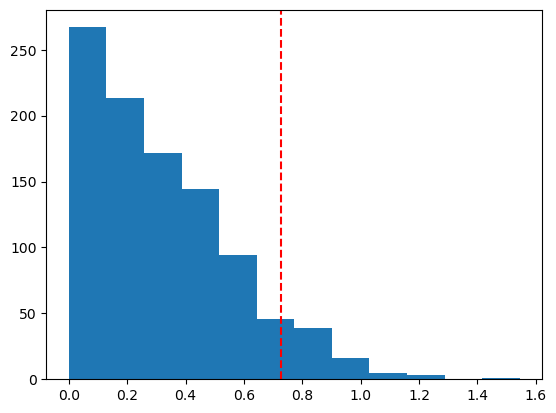

In [323]:
X = np.array([0.2, -1.9, 1.4, -2.7, -1.7, -1.4, 0.3, 1.2, -1.1, -0.2, -2.1])
n = len(X)

n_boot = 1000

print(f"mean of X: {np.mean(X):.3f}  with n={n}")

obs_T = abs(np.mean(X))

Xc = X - np.mean(X)

boot_Ts = np.zeros(n_boot)

for cur_boot in range(n_boot):
  Xboot = np.random.choice(Xc, n, replace=True)
  boot_Ts[cur_boot] = abs(np.mean(Xboot))

boot_pval = sum(boot_Ts >= obs_T)/n_boot

print(f"bootstrap p-value: {boot_pval}")

plt.hist(boot_Ts, bins=12)
plt.axvline(np.abs(obs_T), color='red', linestyle='dashed')

plt.show()

mean of X: 4.273,  mean of Y: 2.429
bootstrap p-value: 0.324


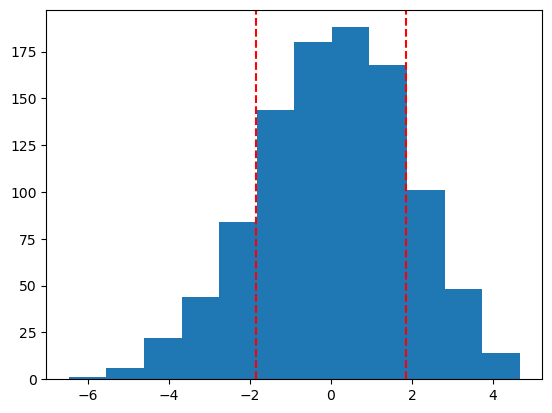

In [336]:
X = np.array([-1, 3, 5, 1, 10, 2, 9, 6, 6, 2, 4])
Y = np.array([11, -2, 1, 0, 0, 5, 2])

n = len(X)
m = len(Y)

n_boot = 1000

Xc = X - np.mean(X)
Yc = Y - np.mean(Y)

print(f"mean of X: {np.mean(X):.3f},  mean of Y: {np.mean(Y):.3f}")

obs_T = np.mean(X) - np.mean(Y)

boot_Ts = np.zeros(n_boot)

for cur_boot in range(n_boot):
  Xboot = np.random.choice(Xc, n, replace=True)
  Yboot = np.random.choice(Yc, m, replace=True)
  boot_Ts[cur_boot] = np.mean(Xboot) - np.mean(Yboot)

boot_pval = sum(np.abs(boot_Ts) >= np.abs(obs_T))/n_boot

print(f"bootstrap p-value: {boot_pval}")

plt.hist(boot_Ts, bins=12)
plt.axvline(np.abs(obs_T), linestyle='dashed', color='red')
plt.axvline(-np.abs(obs_T), linestyle='dashed', color='red')

plt.show()